In [1]:
import os
import shutil
import random
import matplotlib.pyplot as plt
from collections import Counter
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
from keras.applications.resnet50 import ResNet50
import sys
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from functions import plotTraining
from PIL import Image

## Resnet

In [32]:
! pip install tensorflow keras
! pip install opencv-python
! pip install matplotlib
! pip install scikit-learn

   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   - -------------------------------------- 1.6/38.8 MB 9.4 MB/s eta 0:00:04
   --- ------------------------------------ 3.7/38.8 MB 9.9 MB/s eta 0:00:04
   ----- ---------------------------------- 5.8/38.8 MB 10.1 MB/s eta 0:00:04
   -------- ------------------------------- 7.9/38.8 MB 9.9 MB/s eta 0:00:04
   ---------- ----------------------------- 10.2/38.8 MB 10.1 MB/s eta 0:00:03
   ------------ --------------------------- 12.3/38.8 MB 10.3 MB/s eta 0:00:03
   -------------- ------------------------- 14.4/38.8 MB 10.1 MB/s eta 0:00:03
   ---------------- ----------------------- 16.3/38.8 MB 10.0 MB/s eta 0:00:03
   ------------------ --------------------- 18.4/38.8 MB 10.1 MB/s eta 0:00:03
   --------------------- ------------------ 20.7/38.8 MB 10.1 MB/s eta 0:00:02
   ----------------------- ---------------- 23.1/38.8 MB 10.1 MB/s eta 0:00:02
   ------------------------- -------------- 24.9/38.8 MB 10.1 MB/s e

In [33]:
width_shape = 224
height_shape = 224
num_classes = 6
epochs = 50
batch_size = 32 

In [ ]:
train_data_dir = 'images/train'  
validation_data_dir = 'images/validate'

In [35]:
print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)

Keras version: 3.6.0
TensorFlow version: 2.17.0


ImageDataGenerator: This class is used to generate batches of tensor image data with real-time data augmentation. This helps to improve model robustness by preventing overfitting.
* rotation_range: Randomly rotates images within a specified range of degrees (20 degrees in this case).
* zoom_range: Randomly zooms into images (up to 20%).
* width_shift_range and height_shift_range: Randomly shifts the images along the width and height (up to 10% of the total width/height).
* horizontal_flip: Randomly flips the images horizontally.
* vertical_flip: Does not flip images vertically (set to False).
* preprocessing_function: This applies a specified preprocessing function to the images, in this case, preprocess_input from a pre-trained model (like VGG or ResNet).

flow_from_directory: This method generates batches of augmented image data from directories.
* train_data_dir and validation_data_dir: Directories containing the training and validation images organized in subfolders according to their class labels.
* target_size: Resizes all images to the specified dimensions (224x224).
* batch_size: Number of images to be yielded from the generator per iteration (32 in this case).
* class_mode: Determines the type of label arrays that are returned (categorical for multi-class classification).

In [37]:
train_datagen = ImageDataGenerator(  
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

Found 8760 images belonging to 6 classes.
Found 2490 images belonging to 6 classes.


In [38]:
image_input = Input(shape=(width_shape, height_shape, 3))

m_Resnet50 = ResNet50(input_tensor=image_input, include_top=False,weights='imagenet')

m_Resnet50.summary()

last_layer = m_Resnet50.layers[-1].output

x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu', name='fc2')(x)
x=Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_model = Model(image_input, out)
custom_model.summary()

# freeze all the layers except the dense layers
for layer in custom_model.layers[:-6]:
    layer.trainable = False

    
custom_model.summary()

custom_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 36,450,182 (139.05 MB)

 Trainable params: 36,397,062 (138.84 MB)

 Non-trainable params: 53,120 (207.50 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 36,450,182 (139.05 MB)

 Trainable params: 12,862,470 (49.07 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [39]:
# Inicializa un contador para el total de archivos
nb_train_samples = 0
nb_validation_samples = 0

# Recorre cada carpeta dentro de la carpeta 'train'
for folder in os.listdir(train_data_dir):
    folder_path = os.path.join(train_data_dir, folder)
    if os.path.isdir(folder_path):  # Verifica si es un directorio
        # Cuenta el número de archivos en la carpeta actual
        files_count = len(os.listdir(folder_path))
        print(f"Carpeta '{folder}': {files_count} archivos")
        nb_train_samples += files_count

print(f"Total de archivos en 'train': {nb_train_samples}")
      

for folder in os.listdir(validation_data_dir):
    folder_path = os.path.join(validation_data_dir, folder)
    if os.path.isdir(folder_path):  # Verifica si es un directorio
        # Cuenta el número de archivos en la carpeta actual
        files_count = len(os.listdir(folder_path))
        print(f"Carpeta '{folder}': {files_count} archivos")
        nb_validation_samples += files_count
print(f"Total de archivos en 'validate': {nb_validation_samples}")

Carpeta '1.niños': 1460 archivos
Carpeta '2.adolescentes': 1460 archivos
Carpeta '3.jovenes_adultos': 1460 archivos
Carpeta '4.adultos': 1460 archivos
Carpeta '5.adultos_mayores': 1460 archivos
Carpeta '6.tercera_edad': 1460 archivos
Total de archivos en 'train': 8760
Carpeta '1.niños': 415 archivos
Carpeta '2.adolescentes': 415 archivos
Carpeta '3.jovenes_adultos': 415 archivos
Carpeta '4.adultos': 415 archivos
Carpeta '5.adultos_mayores': 415 archivos
Carpeta '6.tercera_edad': 415 archivos
Total de archivos en 'validate': 2490


Clases balanceadas

In [43]:
# Replace the fit_generator method with fit
model_history = custom_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_steps=nb_validation_samples // batch_size
)


c:\Users\marti\OneDrive\Documentos\UCEMA\TFG\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - accuracy: 0.1721 - loss: 2.7456 - val_accuracy: 0.2650 - val_loss: 1.7670
Epoch 2/50
  1/273 ━━━━━━━━━━━━━━━━━━━━ 4:14 934ms/step - accuracy: 0.0312 - loss: 2.2557

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0312 - loss: 2.2557 - val_accuracy: 0.2692 - val_loss: 1.7131
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - accuracy: 0.2358 - loss: 2.0292 - val_accuracy: 0.3080 - val_loss: 1.6679
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2500 - loss: 1.8761 - val_accuracy: 0.1923 - val_loss: 1.7276
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.2652 - loss: 1.8276 - val_accuracy: 0.3417 - val_loss: 1.6034
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3125 - loss: 1.6547 - val_accuracy: 0.3462 - val_loss: 1.6603
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accuracy: 0.2897 - loss: 1.7464 - val_accuracy: 0.3758 - val_loss: 1.5481
Epoch 8/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2500 - loss: 1.7764 - val_accuracy: 0.3462 - val_loss: 1.5841
Epoch 9/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.3075 - loss: 1.6850 - val_accuracy: 0.3661 - 

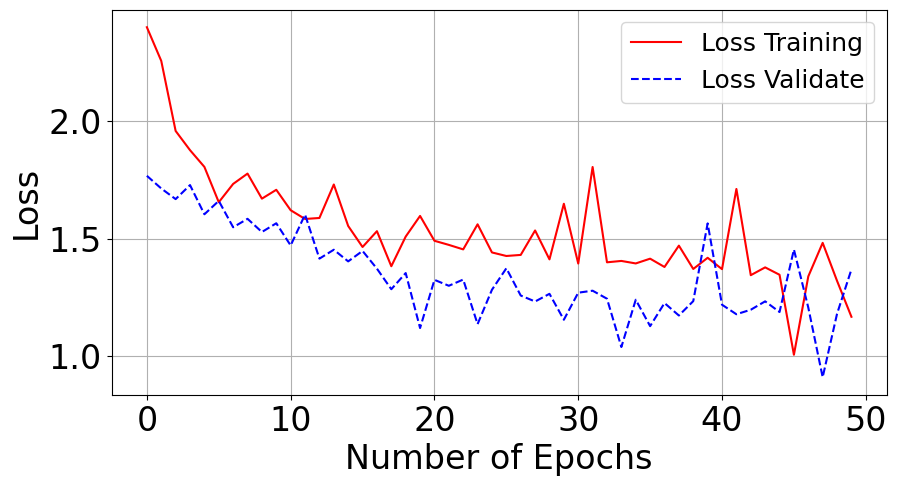

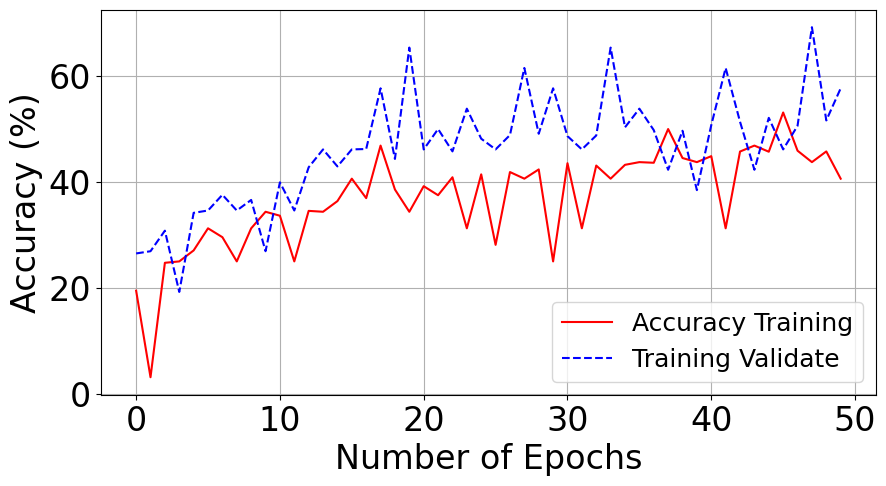

In [45]:
plotTraining(model_history,epochs,"loss")
plotTraining(model_history,epochs,"accuracy")
plotTraining(model_history,epochs,"val_loss")
plotTraining(model_history,epochs,"val_accuracy")

Found 1284 images belonging to 6 classes.
41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 902ms/step


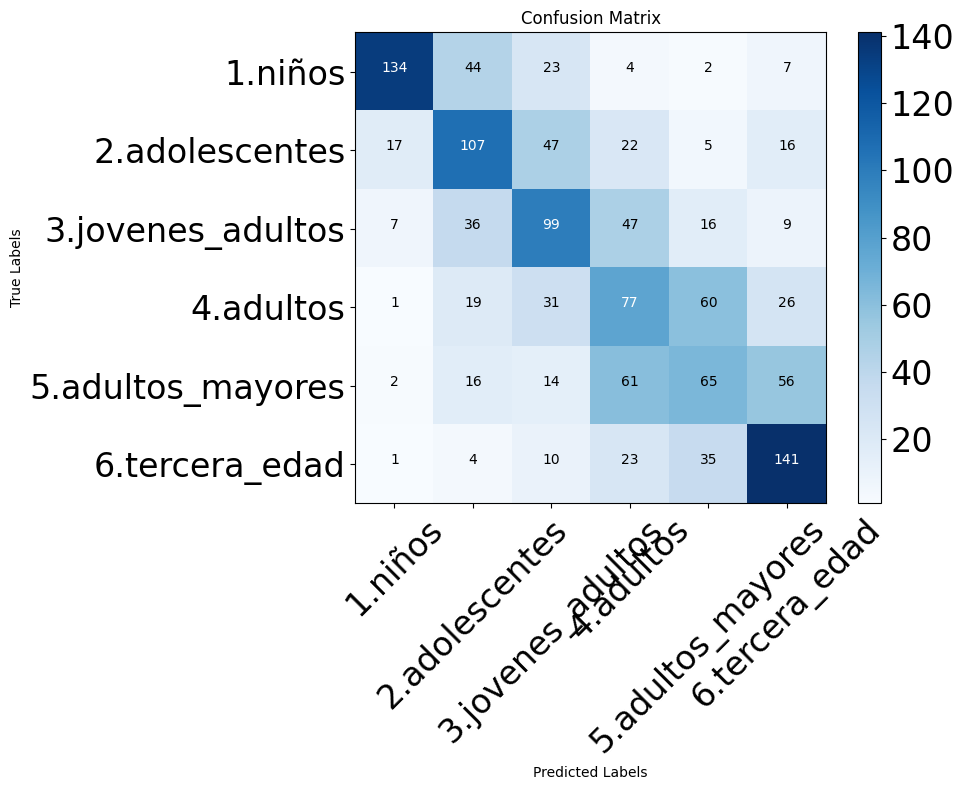

                   precision    recall  f1-score   support

          1.niños     0.8272    0.6262    0.7128       214
   2.adolescentes     0.4735    0.5000    0.4864       214
3.jovenes_adultos     0.4420    0.4626    0.4521       214
        4.adultos     0.3291    0.3598    0.3438       214
5.adultos_mayores     0.3552    0.3037    0.3275       214
   6.tercera_edad     0.5529    0.6589    0.6013       214

         accuracy                         0.4852      1284
        macro avg     0.4966    0.4852    0.4873      1284
     weighted avg     0.4966    0.4852    0.4873      1284



In [ ]:
# Labels for the classes
names = ["1.niños", "2.adolescentes", "3.jovenes_adultos", "4.adultos", "5.adultos_mayores", "6.tercera_edad"]

# Directory containing test data
test_data_dir = 'images/test'

# Initialize ImageDataGenerator for test data
test_datagen = ImageDataGenerator()

# Test data generator
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=False)

# Use the model to predict on test data
predictions = custom_model.predict(test_generator)

# Get the predicted class indices
y_pred = np.argmax(predictions, axis=1)

# Get the actual class indices from the generator
y_real = test_generator.classes

# Create the confusion matrix
matc = confusion_matrix(y_real, y_pred)

# Plot confusion matrix using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(matc, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(names))
plt.xticks(tick_marks, names, rotation=45)
plt.yticks(tick_marks, names)

# Annotate the matrix with the counts
thresh = matc.max() / 2
for i, j in np.ndindex(matc.shape):
    plt.text(j, i, format(matc[i, j], 'd'),
             horizontalalignment="center",
             color="white" if matc[i, j] > thresh else "black")

plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.tight_layout()
plt.show()

# Print classification report
print(classification_report(y_real, y_pred, target_names=names, digits=4))



In [ ]:
custom_model.save("models/model_ResNet50.keras")

Mejores resultados en test, es buen indicio

Si unimos adultos y adultos mayores en una sola categoría tenemos 744 resultados acertados que es un 76% de accuracy

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Carga tu modelo en formato .keras
model = keras.models.load_model("models/model_ResNet50.keras")

# Guarda el modelo en formato SavedModel usando tf.saved_model.save
tf.saved_model.save(model, "models/ResNet50_classification_model")
